In [49]:
import numpy as np
import pickle
import sys
import keras.preprocessing.image 
from keras.models import Sequential,Model,load_model
from keras.preprocessing.image import img_to_array
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Activation, Dropout, Flatten, Dense,  GlobalMaxPooling2D, Lambda, Concatenate
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
from keras.layers import Input
import csv
import pandas as pd   
import os
import h5py
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [50]:
sys.argv[1] = "mhelabd"

In [51]:
#Global Variables
WANTED_BANDS = [3, 2, 1]
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS, NUM_OG_BANDS = (64, 64, len(WANTED_BANDS), 13) 
MODEL_NAME = "Augmented-drop-neighbors-offset-double-CNN-({})-input-({}, {}, {})-bands-({})".format("Resnet50", IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS, str(WANTED_BANDS))
PATH = "/atlas/u/{}/data/kiln-scaling/models/{}/".format(sys.argv[1], MODEL_NAME) 
# DATA_PATH = "/atlas/u/mliu356/data/kiln-scaling/tiles_drop_neighbors/"
DATA_PATH = "/atlas/u/mliu356/data/kiln-scaling/bangladesh_2020_2021/"
MODEL_WEIGHTS_PATH = PATH + "weights/"
MODEL_HISTORY_PATH = PATH + "history/"
MODEL_EVALUATION_PATH = PATH + "evaluation/"
MODEL_EVALUATION_IMAGE_PATH = MODEL_EVALUATION_PATH + "images/"
VERBOSE = True
BALANCE_DATASET = True
USE_BALANCED_DATASET = True
PREPROCESS = False
# BALANCED_DATA_PATH = "/atlas/u/{}/data/kiln-scaling/balanced_tiles/".format(sys.argv[1])
BALANCED_DATA_PATH = "/atlas/u/mhelabd/data/kiln-scaling/balanced_tiles/"
RANDOM_STATE = 42
NUM_RANDOM_IMAGES = 5

In [7]:
def mkdirs(names):
    for name in names:
        if not os.path.exists(name):
            os.makedirs(name)
mkdirs([MODEL_WEIGHTS_PATH, MODEL_HISTORY_PATH, MODEL_EVALUATION_PATH, MODEL_EVALUATION_IMAGE_PATH])

In [52]:
def save_h5_file(X, y, bounds):
    filename = BALANCED_DATA_PATH + ("preprocessed_" if PREPROCESS else "") + "bangladesh_2020_2021.hdf5"
    print("Saving file", filename)
    f = h5py.File(filename, 'w')
    bounds_dset = f.create_dataset("bounds", data=bounds)
    examples_dset = f.create_dataset("images", data=X)
    labels_dset = f.create_dataset("labels", data=y)
    f.close()

def balance_and_save_h5_data(preprocess=False, verbose=VERBOSE):
    X, y = [], []
    print("processing files...")
    for i, filename in enumerate(os.listdir(DATA_PATH)):
        print(".", end="")
        with h5py.File(DATA_PATH + filename, "r") as f:
            if i == 0:
                X = np.array(f["images"][()])\
                    .reshape((-1, NUM_OG_BANDS, IMAGE_HEIGHT, IMAGE_WIDTH))
                y = np.array(f["labels"][()])
                bounds = np.array(f["bounds"][()])
            else:
                x_i = np.array(f["images"][()])\
                    .reshape((-1, NUM_OG_BANDS, IMAGE_HEIGHT, IMAGE_WIDTH))
                X = np.concatenate((X, x_i))

                y_i = np.array(f["labels"][()])
                y = np.concatenate((y, y_i))

                bounds_i = np.array(f["bounds"][()])
                bounds = np.concatenate((bounds, bounds_i))
            try:
                mask = np.isnan(X).any(axis=1).any(axis=1).any(axis=1)
                mask = ~mask
                X, y, bounds = X[mask], y[mask], bounds[mask]
                n = y[y==1].shape[0]
                mask = np.hstack([np.random.choice(np.where(y == l)[0], n, replace=False) for l in np.unique(y)])
                X = X[mask]
                y = y[mask]
                bounds = bounds[mask]
            except ValueError:
                print("file has more positive than negative examples")
    n = min([ y[y==1].shape[0], y[y==0].shape[0] ])
    mask = np.hstack([np.random.choice(np.where(y == l)[0], n, replace=False) for l in np.unique(y)])
    X = X[mask]
    y = y[mask]
    bounds = bounds[mask]
    print("X.shape: ", X.shape)
    print("y.shape: ", y.shape)
    print("bounds.shape: ", bounds.shape)
    
    save_h5_file(X, y, bounds)

In [53]:
balance_and_save_h5_data()

processing files...
.........................................................................file has more positive than negative examples
...............X.shape:  (12658, 13, 64, 64)
y.shape:  (12658, 1)
bounds.shape:  (12658, 4)
Saving file /atlas/u/mhelabd/data/kiln-scaling/balanced_tiles/bangladesh_2020_2021.hdf5


In [69]:
def load_data_from_h5(preprocess=PREPROCESS, verbose=VERBOSE, \
                      balance_dataset=BALANCE_DATASET, use_balanced_dataset=USE_BALANCED_DATASET):
    X, y = [], []
    data_path = BALANCED_DATA_PATH if use_balanced_dataset else DATA_PATH
    if use_balanced_dataset:
        filename = "bangladesh_2020_2021.hdf5"
        with h5py.File(data_path + filename, "r") as f:
            print("extracting: ", filename) 
            X = np.array(f["images"][()])\
                .reshape((-1, NUM_OG_BANDS, IMAGE_HEIGHT, IMAGE_WIDTH))
            X = np.moveaxis(X, 1, -1)[:, :, :, WANTED_BANDS]
            y = np.array(f["labels"][()])
            bounds = np.array(f["bounds"][()])
    else:
        for i, filename in enumerate(os.listdir(data_path)):
            print("extracting: ",filename) 
            with h5py.File(data_path + filename, "r") as f:
                if i == 0:
                    X = np.array(f["images"][()])\
                        .reshape((-1, NUM_OG_BANDS, IMAGE_HEIGHT, IMAGE_WIDTH))
                    X = np.moveaxis(X, 1, -1)[:, :, :, WANTED_BANDS]
                    y = np.array(f["labels"][()])
                    bounds = np.array(f["bounds"][()])
                else:
                    x_i = np.array(f["images"][()])\
                        .reshape((-1, NUM_OG_BANDS, IMAGE_HEIGHT, IMAGE_WIDTH))
                    x_i = np.moveaxis(x_i, 1, -1)[:, :, :, WANTED_BANDS]
                    X = np.concatenate((X, x_i))
                    y_i = np.array(f["labels"][()])
                    y = np.concatenate((y, y_i))

                    bounds_i = np.array(f["bounds"][()])
                    bounds = np.concatenate((bounds, bounds_i))
            
            mask = np.isnan(X).any(axis=1).any(axis=1).any(axis=1)
            mask = ~mask
            X, y, bounds = X[mask], y[mask], bounds[mask]
            
            if balance_dataset:
                #since y = 1 is always less
                n= y[y==1].shape[0]
                mask = np.hstack([np.random.choice(np.where(y == l)[0], n, replace=False)
                                  for l in np.unique(y)])
                X = X[mask]
                y = y[mask]
                bounds = bounds[mask]
    if preprocess:
        X = preprocess_input(X)  
    if verbose:
        print("x shape: ", X.shape)
        print("y shape: ", y.shape)
    return X, y, bounds

In [70]:
def load_data_from_csv(preprocess=True, verbose=VERBOSE):
    for i in range(24):
        if i == 0:
            x_pos = np.loadtxt(DATA_PATH + 'pos_x_examples'+ str(i)+'.csv', delimiter=',')\
                .reshape((-1, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS))
            x_neg = np.loadtxt(DATA_PATH + 'neg_x_examples'+ str(i)+'.csv', delimiter=',')\
                .reshape((-1, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS))
        else:
            x_pos_i = np.loadtxt(DATA_PATH + 'pos_x_examples'+ str(i)+'.csv', delimiter=',')\
                .reshape((-1, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS))
            x_pos = np.concatenate((x_pos, x_pos_i))
            x_neg_i = np.loadtxt(DATA_PATH + 'neg_x_examples'+ str(i)+'.csv', delimiter=',')\
                .reshape((-1, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS))
            x_neg = np.concatenate((x_neg, x_neg_i))
    if verbose:
        print("x_pos.shape: ", x_pos.shape)
        print("x_neg.shape: ", x_neg.shape)
    if preprocess:
        x_pos = preprocess_input(x_pos)
        x_neg = preprocess_input(x_neg)

    X = np.concatenate((x_pos, x_neg))    
    # y is a vector of ones (kilns present) and zeros (kilns absent)
    y = np.concatenate((np.ones(len(x_pos)), np.zeros(len(x_neg) ) )).reshape(-1, 1)
    if verbose:
        print("x shape: ", X.shape)
        print("y shape: ", y.shape)
    return X, y
    

In [71]:
def split_data(X, y, train_percent=0.7, val_percent=0.1, test_percent=0.2):
    assert train_percent + val_percent + test_percent == 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percent, random_state=RANDOM_STATE)
    updated_val_precent = val_percent/(1 - test_percent)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=updated_val_precent, random_state=RANDOM_STATE)
    return (X_train, X_val, X_test, y_train, y_val, y_test)

In [72]:
def crop(start, end):
    # Crops (or slices) a Tensor from start to end
    def func(x):
        return x[:, :, :, start: end]
    return Lambda(func)

In [73]:
def make_double_resnet_model(weights="imagenet", 
               include_top=False, 
               load_weights=None, # path of weights
               loss=keras.losses.binary_crossentropy, 
               optimizer=keras.optimizers.Adam(), 
               metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)]):
    assert NUM_BANDS == 6
    tf.config.experimental_run_functions_eagerly(True)

    model_input = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS))
    infra_input = Lambda(lambda x: x[:, :, :, 0: 3])(model_input)
    rgb_input = Lambda(lambda x: x[:, :, :, 3: 6])(model_input)

    
#     rgb_input = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
#     infra_input = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    resnet_rgb = ResNet50(include_top=include_top, weights=weights, input_tensor=rgb_input, classes=2)
    resnet_color_infra = ResNet50(include_top=include_top, weights=weights, input_tensor=infra_input, classes=2)
    for layer in resnet_color_infra.layers:
        layer._name = layer.name + str("_infra")
    rgb = GlobalMaxPooling2D()(resnet_rgb.output)
    color_infra = GlobalMaxPooling2D()(resnet_color_infra.output)
    x = Concatenate()([rgb, color_infra])
    x = Dense(1024,activation='relu')(x) 
    x = Dense(1024,activation='relu')(x)
    x = Dense(512,activation='relu')(x) 
    x = Dense(512,activation='relu')(x) 
    x = Dense(1, activation= 'sigmoid')(x)
    model = Model(inputs = model_input, outputs = x)
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    if load_weights:
        model.load_weights(load_weights)
    return model



In [59]:
def make_model(weights="imagenet", 
               include_top=False, 
               load_weights=None, # path of weights
               loss=keras.losses.binary_crossentropy, 
               optimizer=keras.optimizers.Adam(), 
               metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)]):
    
    image_input = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS))
    base_model = ResNet50(include_top=include_top, weights=weights, input_tensor=image_input, classes=2)
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(1024,activation='relu')(x) 
    x = Dense(1024,activation='relu')(x) 
    x = Dense(512,activation='relu')(x) 
    x = Dense(1, activation= 'sigmoid')(x)
    model = Model(inputs = base_model.input, outputs = x)
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    if load_weights:
        model.load_weights(load_weights)
    return model


In [60]:
def train_model(model, 
                X_train, 
                y_train,
                X_val,
                y_val,
                trial_name, 
                epochs=20,
                batch_size=64,
                multiprocessing=False, 
                early_stopping=True, 
                save_history=True, 
                datagen=None):
    
    callbacks = []
    
    if early_stopping:
        early_stop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=3, mode='min', verbose=1)
        callbacks.append(early_stop)
    checkpoint_file = MODEL_WEIGHTS_PATH + "{}.h5".format(trial_name)
    checkpoint = ModelCheckpoint(checkpoint_file, 
                                  save_weights_only=True,
                                  monitor='val_accuracy',
                                  mode='max',
                                  save_best_only=False)
    callbacks.append(checkpoint)                        
    if datagen != None:
        history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                        validation_data=(X_val, y_val), 
                        steps_per_epoch=len(X_train) // batch_size,
                        use_multiprocessing=multiprocessing, 
                        epochs=epochs, 
                        callbacks=callbacks)
    else: 
        history = model.fit(x=X_train,
                        y=y_train,
                        epochs=epochs, 
                        batch_size=batch_size, 
                        use_multiprocessing=multiprocessing, 
                        validation_data=(X_val, y_val), 
                        callbacks=callbacks)
    if save_history:
        with open(MODEL_HISTORY_PATH + trial_name, 'wb') as file_pi:
            pickle.dump(history.history, file_pi)
    return model, history

In [61]:
def graph_model_performance(history):
    # IF METRICS ARE UPDATED, YOU MUST UPDATE THIS
    # summarize history for accuracy
    plt.plot(list(history['binary_accuracy']))
    plt.plot(list(history['val_binary_accuracy']))
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    plt.savefig(MODEL_EVALUATION_PATH + "accuracy.png")
    plt.clf()
    # summarize history for loss
    plt.plot(list(history['loss']))
    plt.plot(list(history['val_loss']))
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    plt.savefig(MODEL_EVALUATION_PATH + "loss.png")
    plt.clf()

In [62]:
def print_images(x, name):
    normalized_x = x/np.max(x)
    plt.imshow(normalized_x)
    plt.show()
    plt.savefig(MODEL_EVALUATION_IMAGE_PATH + name)
    plt.clf()
def evaluate_dataset(model, X, y, threshold=0.5, pictures=True, dataset_type="test"):
    # Evaluate the model on the test data using `evaluate`
    results = model.evaluate(X, y, batch_size=128)
    print(dict(zip(model.metrics_names, results)))

    y_pred = model.predict(X) > threshold
    print(tf.math.confusion_matrix(y.reshape(-1), y_pred.reshape(-1)))
    
    if pictures:
        print("Generating {} false positives and {} false negatives...".format(NUM_RANDOM_IMAGES, NUM_RANDOM_IMAGES))

        false_positives = np.logical_and(y != y_pred, y_pred == 1)
        X_fp = X[false_positives.reshape(-1), :, :]
        #gets you the location of every false positive in X
        false_positives_index = np.argwhere(false_positives)

        false_negatives = np.logical_and(y != y_pred, y_pred == 0)
        X_fn = X[false_negatives.reshape(-1), :, :]
        false_negatives_index = np.argwhere(false_negatives)

        
        for i in range(NUM_RANDOM_IMAGES):
            if len(X_fp) > 0:
                randi = np.random.randint(0, len(X_fp))
                X_fp_i = false_positives_index[randi][0]
                confidence = model.predict(np.expand_dims(X[X_fp_i], axis=0))[0][0]
                print_images(X_fp[randi], "{}_fp_example{}_confidence_{}_coordinates({}).png"\
                             .format(dataset_type, X_fp_i, confidence, str(bounds[X_fp_i])))
            if len(X_fn) > 0:
                randi = np.random.randint(0, len(X_fn))
                X_fn_i = false_negatives_index[randi][0]
                confidence = model.predict(np.expand_dims(X[X_fn_i], axis=0))[0][0]
                print_images(X_fn[randi],  "{}_fn_example{}_confidence_{}_coordinates({}).png"\
                             .format(dataset_type, X_fn_i, confidence, str(bounds[X_fn_i])))

def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, threshold=0.5, pictures=True):
    print("Evaluating Training data: ")
    evaluate_dataset(model, X_train, y_train, threshold=threshold, pictures=pictures, dataset_type="train")

    print("Evaluating Validation data: ")
    evaluate_dataset(model, X_val, y_val, threshold=threshold, pictures=pictures, dataset_type="val")

    print("Evaluating Test data: ")
    evaluate_dataset(model, X_test, y_test, threshold=threshold, pictures=pictures, dataset_type="test")


In [63]:
def visualize_tile(image, indices=[3, 2, 1]):
    row_idx = np.array(indices)
    X = image
    X *= 1 / np.max(X)
    print(X.shape)
    plt.imshow(X)
def Augment_data():
    datagen = keras.preprocessing.image.ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True
    )
    return datagen

In [64]:
def remove_nans(X, y, bounds):
    mask = np.isnan(X).any(axis=1).any(axis=1).any(axis=1)
    mask = ~mask
    X, y, bounds = X[mask], y[mask], bounds[mask]
    #since y = 1 is always less
    n= min(y[y==1].shape[0], y[y==0].shape[0])
    mask = np.hstack([np.random.choice(np.where(y == l)[0], n, replace=False)
                          for l in np.unique(y)])
    X, y, bounds = X[mask], y[mask], bounds[mask]
    print("X shape: ", X.shape)
    print("y shape: ", y.shape)
    return X, y, bounds

In [74]:
X, y, bounds = load_data_from_h5()

extracting:  bangladesh_2020_2021.hdf5
x shape:  (12658, 64, 64, 3)
y shape:  (12658, 1)


In [75]:
X, y, bounds = remove_nans(X, y, bounds)

X shape:  (12658, 64, 64, 3)
y shape:  (12658, 1)


99/99 [==============================] - 2s 20ms/step - loss: 0.2884 - binary_accuracy: 0.9452
{'loss': 0.28838443756103516, 'binary_accuracy': 0.945181667804718}
tf.Tensor(
[[6107  223]
 [ 471 5859]], shape=(2, 2), dtype=int32)
Generating 5 false positives and 5 false negatives...


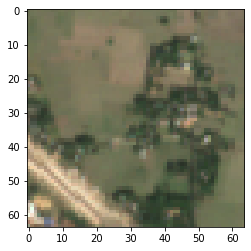

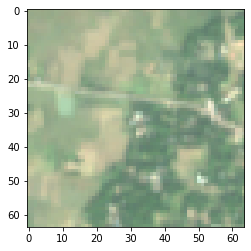

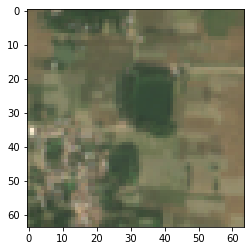

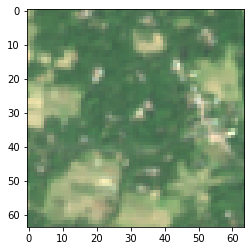

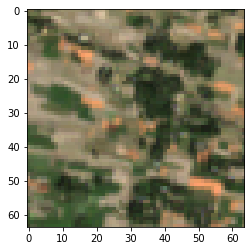

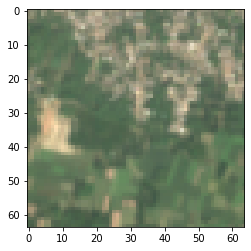

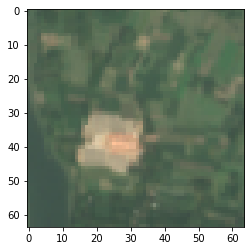

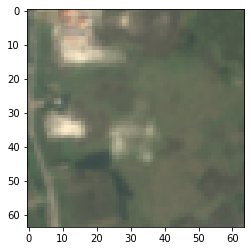

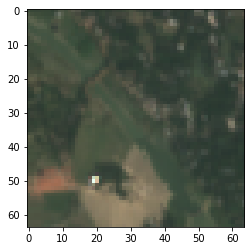

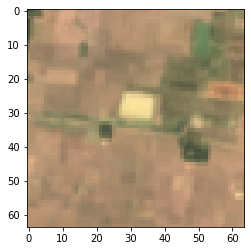

<Figure size 432x288 with 0 Axes>

In [68]:
evaluate_dataset(model, X, y, threshold=0.5, pictures=True, dataset_type="test")

99/99 [==============================] - 2s 23ms/step - loss: 0.3371 - binary_accuracy: 0.9407
{'loss': 0.33714741468429565, 'binary_accuracy': 0.9406699538230896}
tf.Tensor(
[[6159  170]
 [ 581 5748]], shape=(2, 2), dtype=int32)
Generating 5 false positives and 5 false negatives...


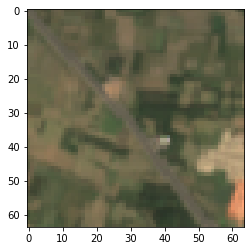

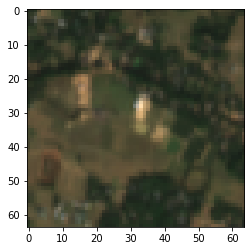

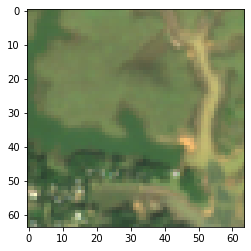

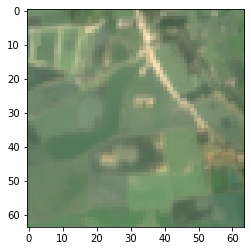

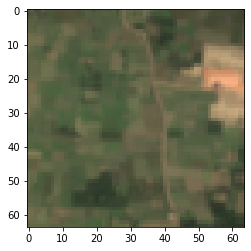

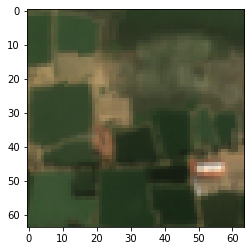

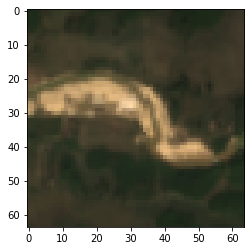

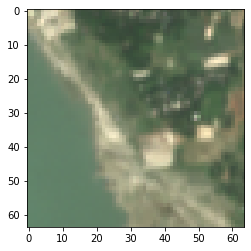

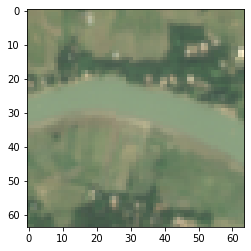

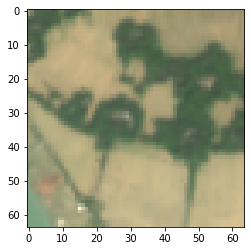

<Figure size 432x288 with 0 Axes>

In [76]:
evaluate_dataset(model, X, y, threshold=0.5, pictures=True, dataset_type="test")

In [ ]:
i = 6520
visualize_tile(X[i]), y[i]

In [34]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, train_percent=0.7, val_percent=0.1, test_percent=0.2)

In [35]:
# model = make_model()
model = make_double_resnet_model()

In [36]:
# model, history = train_model(model, X_train, y_train, X_val, y_val, "trial_4_epoch_35", epochs=250, save_history=False)
model, history = train_model(model, 
                             X_train, 
                             y_train, 
                             X_val, 
                             y_val, 
                             "trial_6_epoch_55", 
                             epochs=55, 
                             batch_size=32,
                             save_history=True,
                             early_stopping=False, 
                             multiprocessing=True,
                             datagen=None)

Epoch 1/55
274/274 [==============================] - 128s 469ms/step - loss: 0.4423 - binary_accuracy: 0.8934 - val_loss: 1.7924 - val_binary_accuracy: 0.8059
Epoch 2/55
274/274 [==============================] - 129s 470ms/step - loss: 0.3439 - binary_accuracy: 0.9369 - val_loss: 1.3219 - val_binary_accuracy: 0.7276
Epoch 3/55
274/274 [==============================] - 129s 470ms/step - loss: 0.4811 - binary_accuracy: 0.9232 - val_loss: 6.4608 - val_binary_accuracy: 0.5631
Epoch 4/55
274/274 [==============================] - 129s 470ms/step - loss: 0.5884 - binary_accuracy: 0.9203 - val_loss: 2.0663 - val_binary_accuracy: 0.8219
Epoch 5/55
274/274 [==============================] - 129s 470ms/step - loss: 0.2892 - binary_accuracy: 0.9474 - val_loss: 0.4282 - val_binary_accuracy: 0.9265
Epoch 6/55
274/274 [==============================] - 129s 469ms/step - loss: 0.2418 - binary_accuracy: 0.9541 - val_loss: 0.2466 - val_binary_accuracy: 0.9393
Epoch 7/55
274/274 [====================

Epoch 52/55
274/274 [==============================] - 129s 471ms/step - loss: 0.3381 - binary_accuracy: 0.9739 - val_loss: 0.3620 - val_binary_accuracy: 0.9521
Epoch 53/55
274/274 [==============================] - 129s 470ms/step - loss: 0.2667 - binary_accuracy: 0.9787 - val_loss: 0.4758 - val_binary_accuracy: 0.9449
Epoch 54/55
274/274 [==============================] - 129s 471ms/step - loss: 0.2700 - binary_accuracy: 0.9776 - val_loss: 0.9105 - val_binary_accuracy: 0.9209
Epoch 55/55
274/274 [==============================] - 129s 471ms/step - loss: 0.2147 - binary_accuracy: 0.9816 - val_loss: 0.6063 - val_binary_accuracy: 0.9393


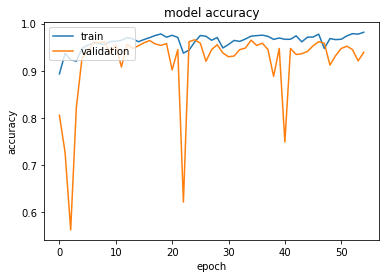

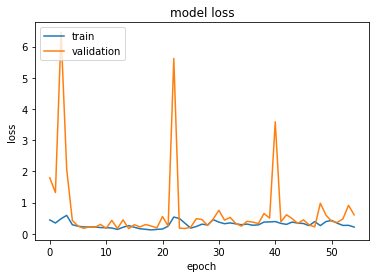

<Figure size 432x288 with 0 Axes>

In [37]:
graph_model_performance(history.history)

In [42]:
evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, pictures=False)

Evaluating Training data: 
69/69 [==============================] - 12s 169ms/step - loss: 0.2239 - binary_accuracy: 0.9828
{'loss': 0.22385555505752563, 'binary_accuracy': 0.9827625751495361}
tf.Tensor(
[[4263  119]
 [  32 4346]], shape=(2, 2), dtype=int32)
Evaluating Validation data: 
10/10 [==============================] - 2s 164ms/step - loss: 0.6063 - binary_accuracy: 0.9393
{'loss': 0.6062620282173157, 'binary_accuracy': 0.9392971396446228}
tf.Tensor(
[[570  39]
 [ 37 606]], shape=(2, 2), dtype=int32)
Evaluating Test data: 
20/20 [==============================] - 3s 168ms/step - loss: 0.5415 - binary_accuracy: 0.9433
{'loss': 0.5415011048316956, 'binary_accuracy': 0.9432907104492188}
tf.Tensor(
[[1196   71]
 [  71 1166]], shape=(2, 2), dtype=int32)


In [ ]:
MODEL_EVALUATION_IMAGE_PATH